In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Titanic Top 4% with ensemble modeling

## 1. Introduction
* Feature analysis
* Feature engineering
* Modeling

In [2]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data

### 2.1 Load data

In [3]:
# 데이터 불러오기
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
IDtest = test['PassengerId']

### 2.2 Outlier detection

In [4]:
# 이상치를 찾는 함수
def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25) # 1사분위수
        Q3 = np.percentile(df[col], 75) # 3사분위수
        IQR = Q3 - Q1 # 사분위범위
        
        outlier_step = 1.5 * IQR # 이상치 범위
        
        # 해당 feature에서 이상치를 가지는 인덱스 저장
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        # 모든 이상치 인덱스를 oulier_indices에 추가
        outlier_indices.extend(outlier_list_col)
    
    # 이상치를 가지는 feature가 2개 이상인 인덱스를 찾음
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

# 'Age', 'SibSp', 'Parch', 'Fare'에서 이상치 찾기
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

예측(특히, 회귀분석)에 이상치가 큰 영향을 줄 수 있음
- Turky method: IQR을 사용하여 이상치 탐색

수치 변수를 가지는 Age, SibSp, Parch, Fare에서 이상치 탐지하여, 2개 이상의 컬럼에서 이상치를 가지는 index를 이상치로 간주

In [5]:
train.loc[Outliers_to_drop] # 2개 이상의 이상치를 가지는 행

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 이상치를 찾음
- 28, 89, 342 승객은 높은 Fare를 가지고,
- 나머지 7명의 승객은 SibSp값이 매우 높음

In [6]:
# 이상치 삭제
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

### 2.3 joining train and test set

* objs: 다중 데이터 프레임을 한 번에 합칠 때 사용

In [7]:
train_len = len(train)
dataset = pd.concat(objs=[train,test], axis=0).reset_index(drop=True) # 행 방향으로 train, test 병합

### 2.4 check for null and missing values

In [8]:
dataset = dataset.fillna(np.nan) # 빈 값을 NaN으로 채움
dataset.isnull().sum() # 결측치 개수

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

- Survived는 train에만 존재하기 때문에 test에서 결측치가 발생한 것
- Age와 Cabin에 결측치 대량 존재

In [9]:
# train 기본 정보
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
# 요약
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature analysis

### 3.1 Numerical values

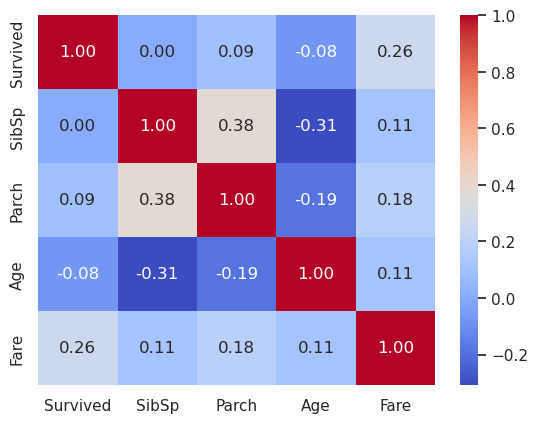

In [13]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt = '.2f', cmap='coolwarm')

Fare와 Survived만 연관이 있는 것으로 보임.

그렇다고 해서 다른 feature들이 상관없다는 것은 아님.
- 이를 확인하기 위해 feature 하나씩 살펴보아야 함.


**SibSp**

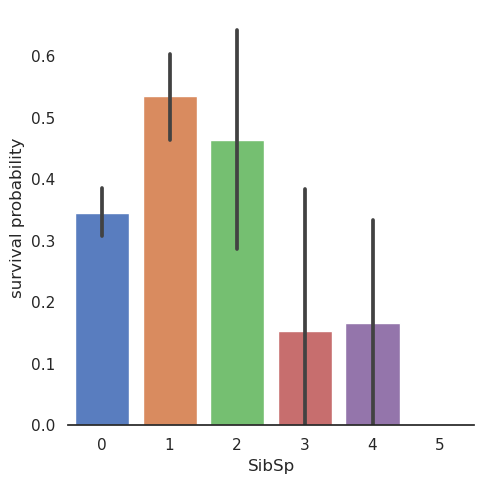

In [14]:
g = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

많은 형제/부모가 있으면 생존 확률이 낮음을 알 수 있음
- 혼자 탑승한 승객(=0) 또는 1,2명의 동승자가 있는 경우 더 높은 생존 확률을 가짐

feature engineering을 통해 이러한 카테고리의 새로운 feature를 설명할 수 있음

**Parch**

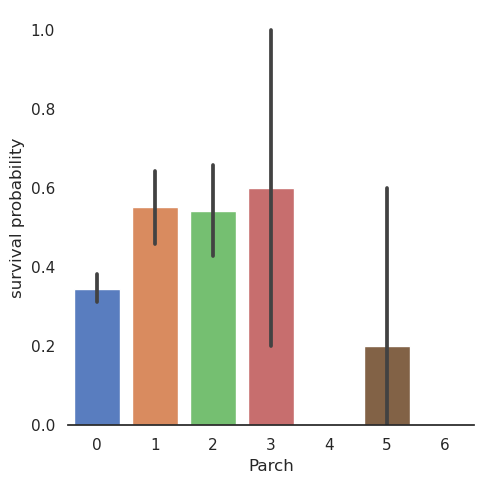

In [15]:
g = sns.catplot(x='Parch', y='Survived', data=train, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

소가족인 경우 생존 가능성이 더 높다.
- 혼자인 경우 보다(Parch = 0)
- medium families 보다 (Parch = 3, 4)
- lage families 보다 (Parch = 5, 6)

부모/자녀가 3명인 승객의 생존에 표준편차가 있음을 주의

**Age**

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


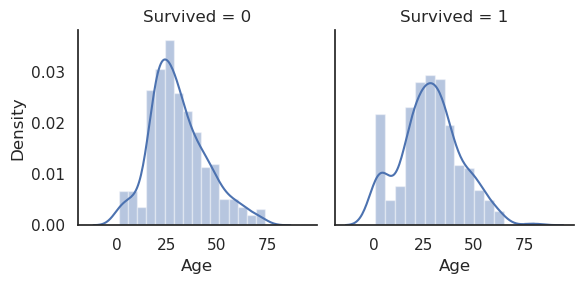

In [16]:
g = sns.FacetGrid(train, col='Survived') # col에 따른 그래프
g = g.map(sns.distplot, 'Age')

Age 분포는 꼬리가 있는 분포, 가우시안 분포로 보임
- 생존한 집단과, 생존하지 않은 집단의 연령 분포가 다름.
- 생존한 어린 승객에 해당하는 봉우리가 존재.
- 60-80세 승객들은 대부분은 생존하지 못함.

=> Age와 Survived는 상관관계가 없다고 하더라도, 승객들이 생존할 기회가 더 많거나 적은 연령대가 있음을 알 수 있음

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  This is separate from the ipykernel package so we can avoid doing imports until


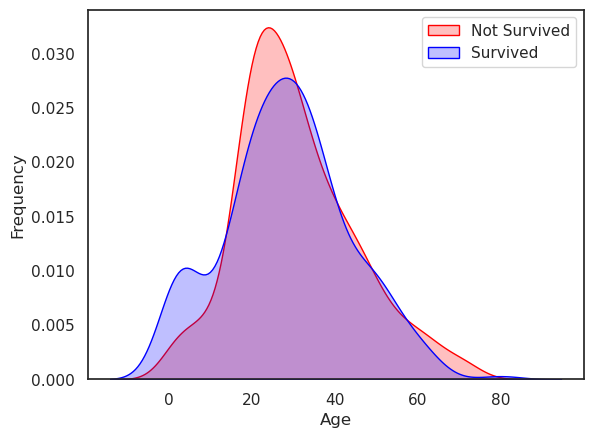

In [17]:
# Age 분포 
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

두 kde를 중접하면 어린 아이들인 0-5세에서 봉우리가 있음을 명확하게 볼 수 있음

**Fare**

In [18]:
dataset['Fare'].isnull().sum()

1

In [19]:
# 결측치를 중앙값으로 채움
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

1개의 결측치가 있지만, 중앙값으로 채워도 예측에는 큰 영향이 가지 않을 것으로 판단.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


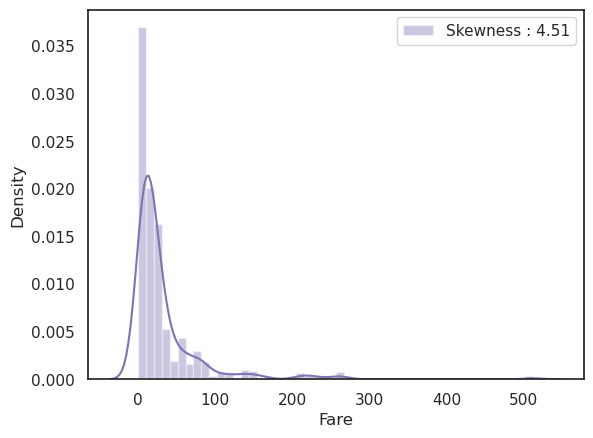

In [20]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

그래프를 보다시피, Fare는 매우 편향되어 있음
- 값을 조정하더라도, 모델에서 매우 높은 값이 초과될 수 있음
- 왜곡을 줄이기 위해 `로그함수`로 변환하는 것이 좋음

In [21]:
# 왜도 분포를 줄이기 위해 Fare에 log 함수 적용
dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i>0 else 0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


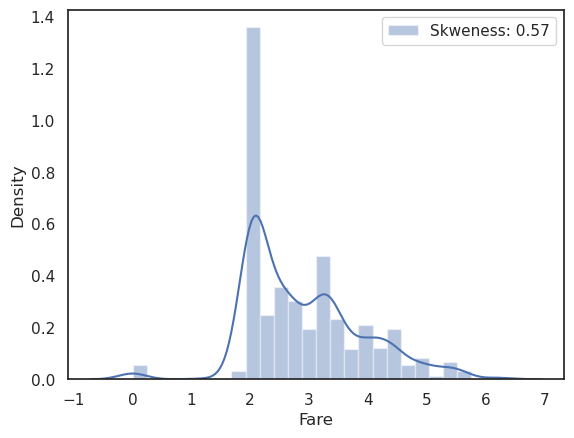

In [22]:
g = sns.distplot(dataset['Fare'], color='b', label='Skweness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

로그 변환을 통해 왜도가 확실히 줄었음

### 3.2 Categorical values

**Sex**

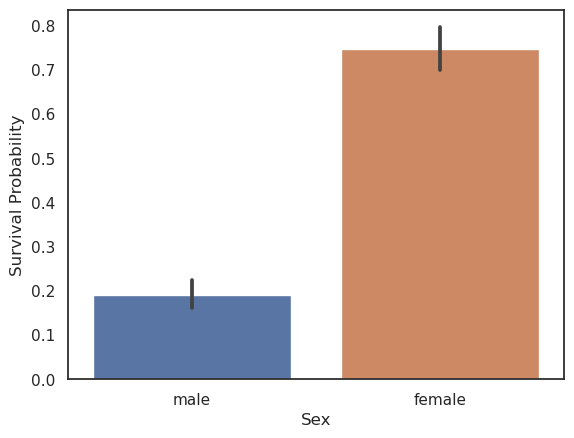

In [23]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel("Survival Probability")

In [24]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남자는 여자에 비해 생존 가능성이 적음
- Sex는 생존 예측에 있어 매우 중요한 역할


**Pclass**

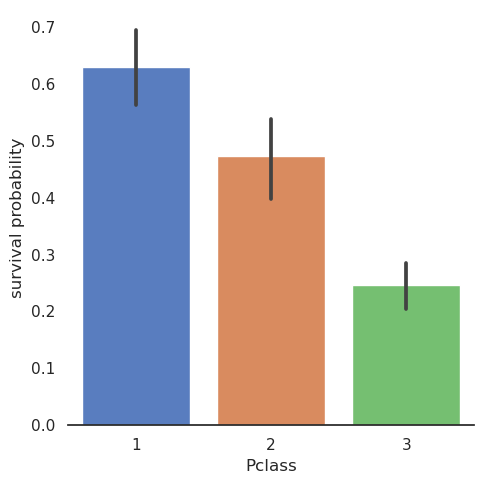

In [25]:
g = sns.catplot(x='Pclass', y='Survived', data=train, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

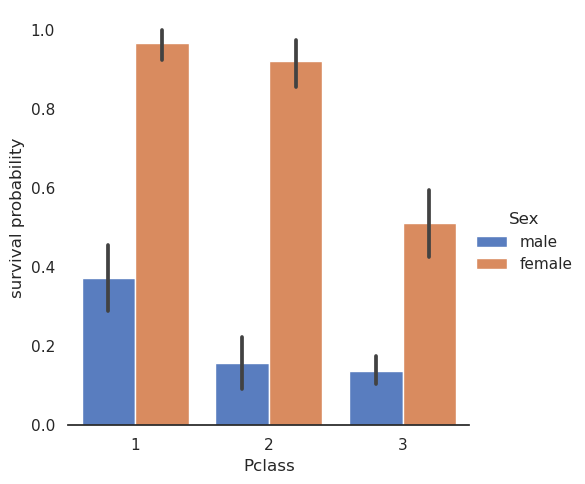

In [26]:
g = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

3개의 등급에서 승객들의 생존은 같지 않음
- 1등석 탑승객은 2,3등석 탑승객보다 생존 가능성이 높음
- 이러한 추세는, 남여 모두에 해당 

**Embarked**

In [27]:
dataset['Embarked'].isnull().sum()

2

In [28]:
# Embarked 결측치를 가장 높은 빈도수를 가지는 'S'로 채움
dataset['Embarked'] = dataset['Embarked'].fillna('S')

Embarked 2개의 결측치를 가장 높은 빈도수를 가지는 'S'로 채움

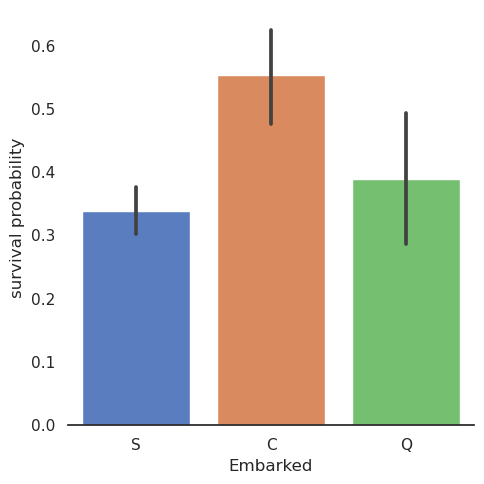

In [29]:
g = sns.catplot(x='Embarked', y='Survived', data=train, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

C 항구에서 탑승한 승객들의 생존률이 높음
- Q, S보다 C 항구에서 1등석 탑승객이 더 많이 탑승했을 것이라는 추측


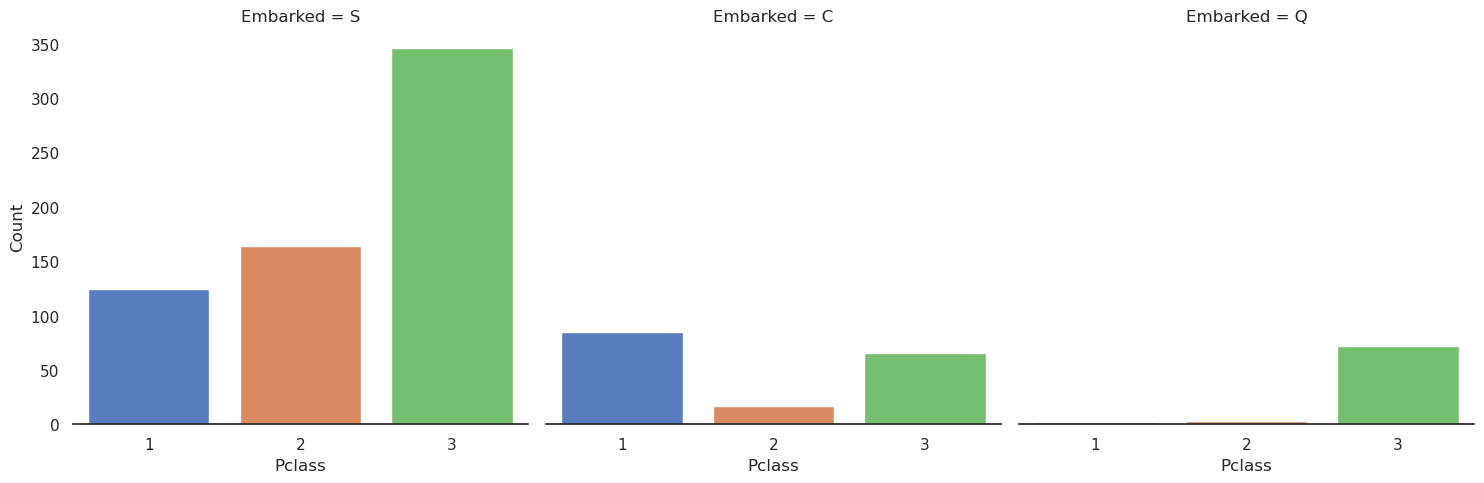

In [30]:
g = sns.catplot(x='Pclass', col='Embarked', data=train, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels("Count")

실제로, S, Q 항구에서 3등급 탑스액이 매우 많았으며, 높은 생존율를 보인 1등석 탑승객은 대부분 C 항구임을 알 수 있음 

## 4. Filling missing Values

### 4.1 Age
Age는 전체에서 256개의 결측치가 존재함
- 생존 가능성이 높은 부분집단이 존재하므로 연령 특성은 유지하되, 결측치를 대치하는 것이 좋음
- 이 문제를 해결하기 위해, Age와 관련있는 feature를 살펴봄(Sex, Parch, Pclass, SibSp)

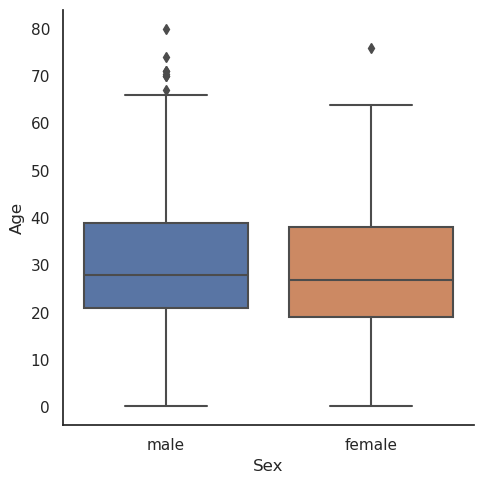

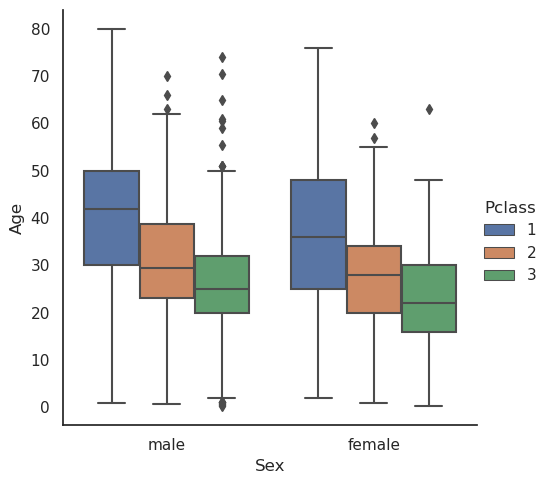

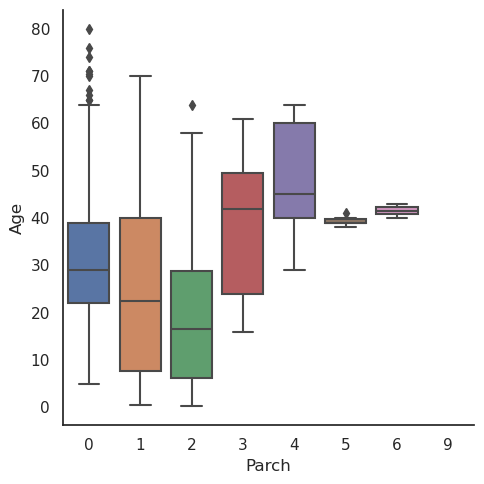

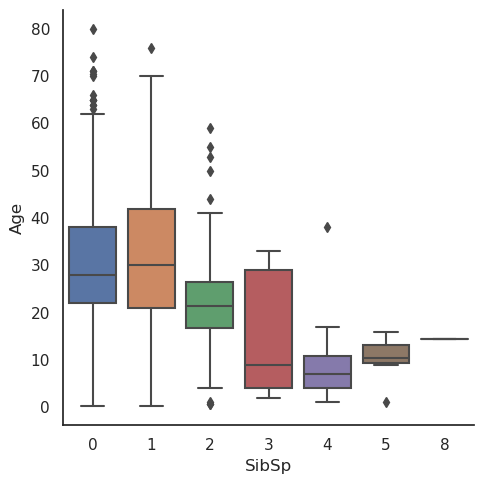

In [31]:
g = sns.catplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.catplot(y='Age', x='SibSp', data=dataset, kind='box')

- 남여 부분집단에서 Age 분포는 비슷해보이므로, Age 예측에 Sex는 유익하지 않음
- 1등급 승객은 2등급 승객보다 나이가 많고, 2등급 승객은 3등급 승객보다 나이가 많음
- 부모/자식이 많을 수록 본인 나이가 많고, 형제/배우자가 많을 수록 본인 나이가 적음

In [32]:
# Sex의 male, female을 각각 0,1로 바꿈
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

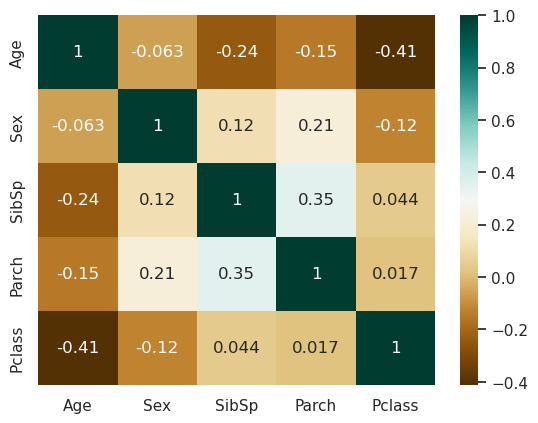

In [33]:
g = sns.heatmap(dataset[['Age', 'Sex','SibSp','Parch','Pclass']].corr(), cmap='BrBG', annot=True)

- Age는 Sex와 상관없으며, Pclass, Parch, SipSp와는 음의 상관관계를 가짐
- Age는 Parch(부모/자녀)가 커질수록 증가하지만, 일반적으로 음의 상관관계

=> 누락된 나이를 대체하기 위해 SibSp, Parch, Pclass를 사용
- Pclass, Parch, SibSp에 따라 Age의 중앙값을 구해 결측치 대체

In [34]:
# Age 결측치 채우기
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)
for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp'])
                               & (dataset['Parch'] == dataset.iloc[i]['Parch'])
                               & (dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

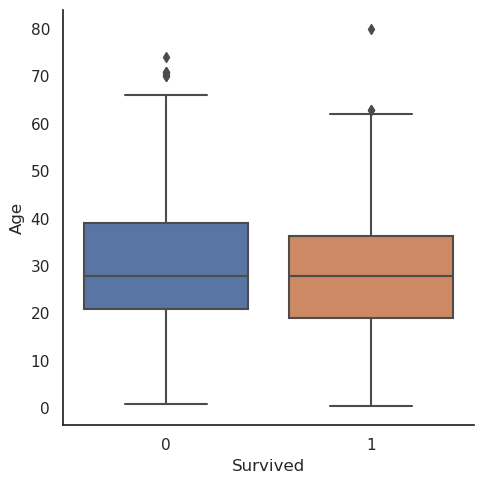

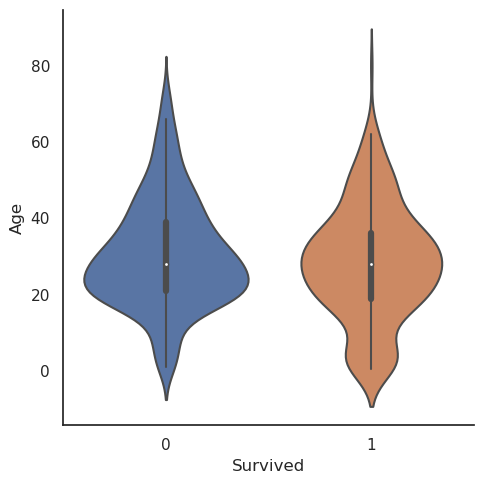

In [35]:
g = sns.catplot(x='Survived', y='Age', data=train, kind='box')
g = sns.catplot(x='Survived', y='Age', data=train, kind='violin')

생존한 집단과, 생존하지 못한 집단 간의 Age 중앙값에는 큰 차이가 없음

생존한 승객의 violinplot에서 어린 승객들이 더 높은 생존율을 가지고 있음을 알 수 있음

## 5. Feature engineering

### 5.1 Name/Title

In [36]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Name에는 승객들의 정보가 포함되어 있음
- 구분되는 이름을 가진 몇몇 승객들은 탈출하는 동안 선호되었을 수도 있으므로, 모델에 추가하면 흥미로울 것임

In [37]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

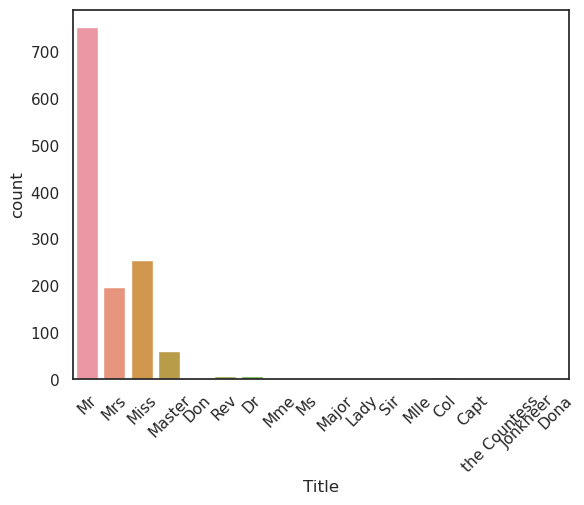

In [38]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

데이터셋에는 17개의 title이 존재하고, 대부분은 희귀하기 때문에 우리는 4 그룹으로 나눌 수 있음

In [39]:
# Categorical로 바꾸기
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

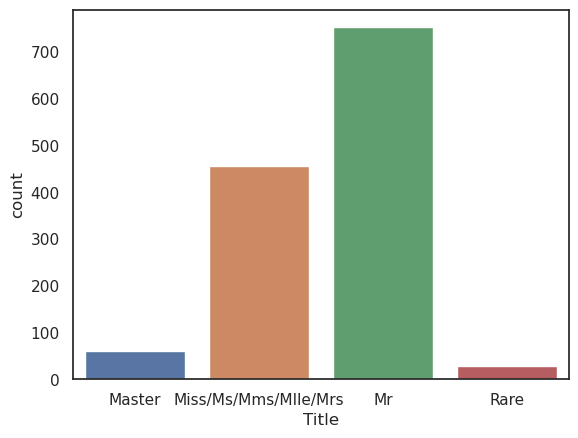

In [40]:
g = sns.countplot(x=dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mms/Mlle/Mrs', 'Mr', 'Rare'])

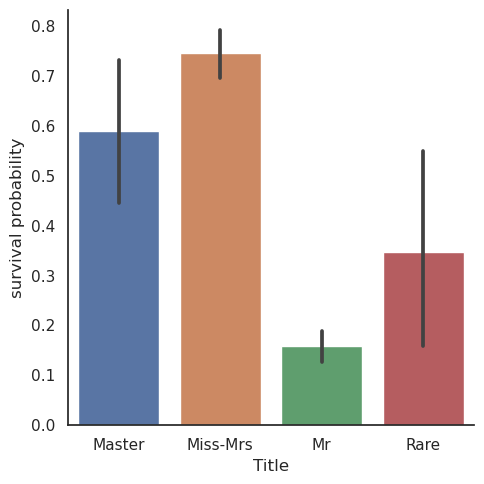

In [41]:
g = sns.catplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

"여성과 아이 먼저"
- Rare한 title을 가진 승객들은 생존 가능성이 더 높음

In [42]:
# Name 변수 삭제
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

### 5.2 Family size
대가족은 그들의 자매/형제/부모를 챙겨야 하기 때문에 생존하기에 어려울 것으로 추측됨
- SibSp + Parch + 1을 의미하는 Fize(Family size)라는 변수를 만듦

In [43]:
# Fize 만들기
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

/opt/conda/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


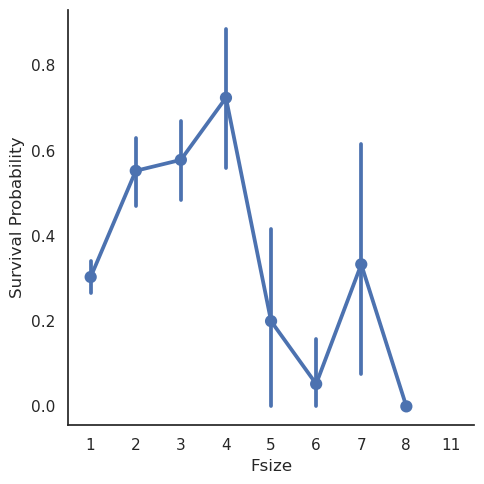

In [44]:
g = sns.catplot(x='Fsize', y='Survived', data=dataset, kind='point')
g = g.set_ylabels('Survival Probability')

대가족에서 가장 나쁜 생존 가능성을 보인 것으로 보아, family size는 큰 역할을 하는 것으로 보임

In [45]:
# family size에 대한 새로운 컬럼 만들기
dataset['Single'] = dataset['Fsize'].map(lambda s:1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s:1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s:1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s:1 if s >= 5 else 0)

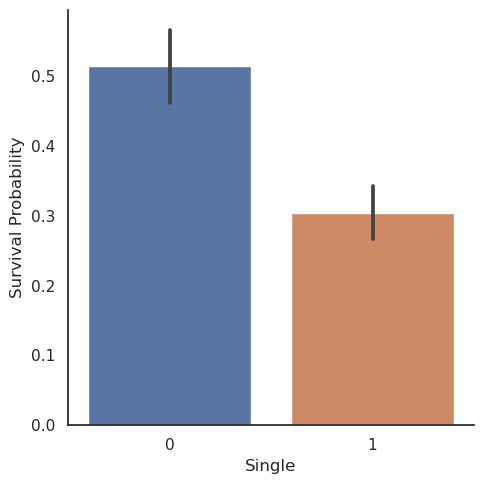

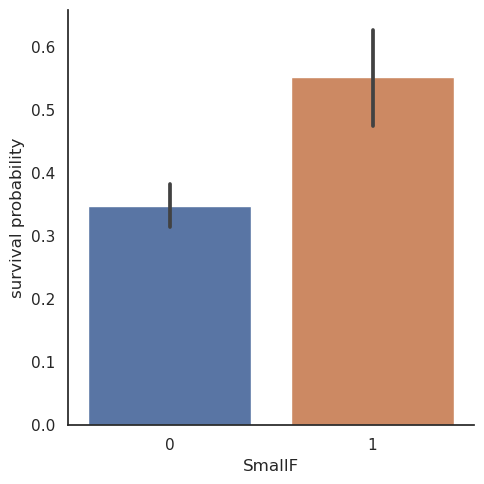

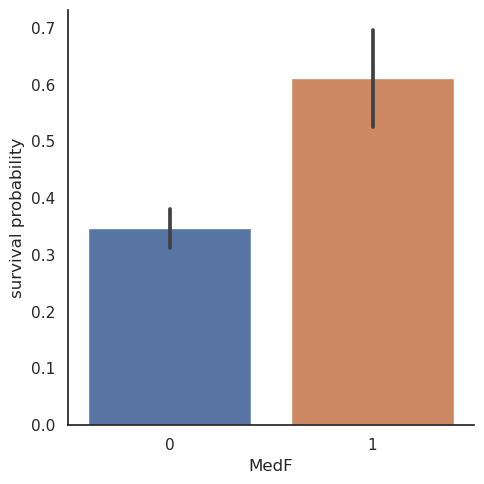

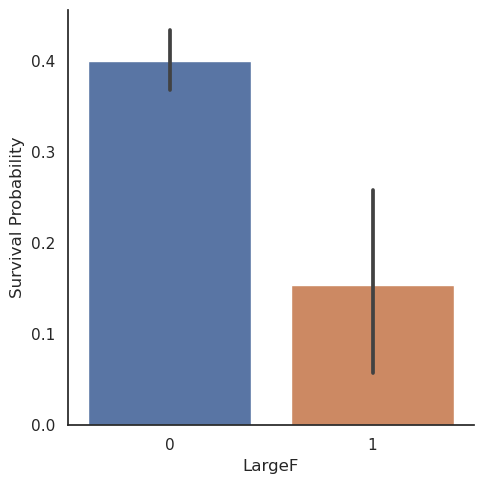

In [46]:
g = sns.catplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('survival probability')

g = sns.catplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('survival probability')

g = sns.catplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

faimly size에 대한 catplot을 통해 Small, Medium 가족이 single, large 가족보다 더 많이 생존했음을 알 수 있음

In [47]:
# Title, Embarked 더미변수 만들기
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [48]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


이 단계를 통해, 우리는 feature는 22개가 됨

### Cabin

In [49]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [50]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [51]:
dataset['Cabin'].isnull().sum()

1007

Cabin에는 292개의 값과 1007개의 결측치가 존재함
- 객실이 없는 승객이 Cabin이 결측치로 존재

In [52]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [53]:
# 결측치를 'X'로 대체
dataset['Cabin'] = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'])

Cabin의 첫 글자는 Desk를 나타내며, 이 desk는 탑승한 승객이 가능한 위치를 나타내므로 첫 글자만 남김

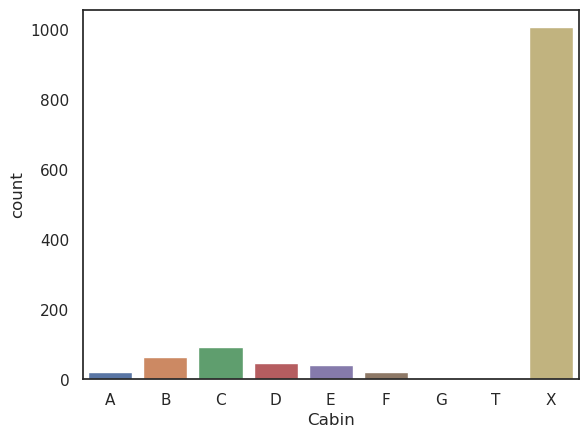

In [54]:
g = sns.countplot(x=dataset['Cabin'], order=['A','B','C','D','E','F','G','T','X'])

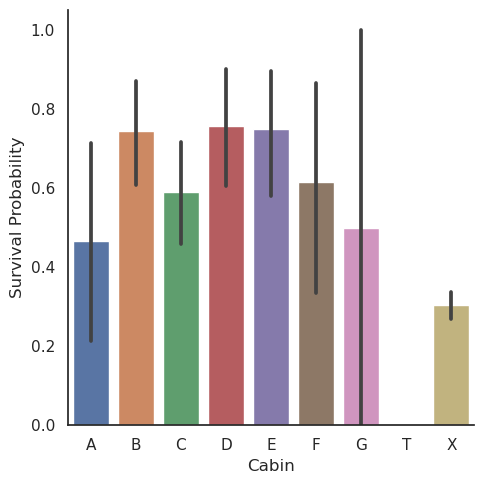

In [55]:
g = sns.catplot(x='Cabin', y='Survived', data=dataset, kind='bar', order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels('Survival Probability')

Cabin을 가진 승객 수가 적기 때문에, 생존 확률은 중요한 표준편차를 가지고 있고 우리는 다른 desk에 있는 승객들 간의 생존 확률을 구별할 수 없음

하지만, Cabin이 없는 승객(X)보다 있는 승객들이 일반적으로 더 높은 생존 가능성을 가짐을 볼 수 있음
- B,C,D,E,F에서 이를 볼 수 있음

In [56]:
# Cabin 더미변수 생성
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

### 5.4 Ticket

In [57]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

같은 접두사를 가지는 티켓이 같은 객실을 예약했음을 의미
- 같은 접두사를 가지는 티켓은 비슷한 class와 survival을 가질 것임
- Ticket 컬럼을 티켓 접두사로 바꾸면 더 유익할 것임

In [58]:
# Ticket에서 접두사만 추출하기. 없으면 'X'
Ticket = []
for i in list(dataset['Ticket']):
    if not i.isdigit():
        Ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0]) # 접두사
    else:
        Ticket.append('X')
        
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [59]:
# Ticket 더미변수 생성
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [60]:
# Pclass 더미변수 생성
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix='Pc')

In [61]:
# 필요없는 변수 제거
dataset.drop(labels = ['PassengerId'], axis=1, inplace=True)

In [62]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## 6. Modeling

In [63]:
# train, test 분리
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels='Survived', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [64]:
# 훈련 feature와 label 분리
train['Survived'] = train['Survived'].astype(int)
Y_train=train['Survived']
X_train=train.drop(labels=['Survived'], axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 6.1 Simple modeling

#### 6.1.1 Cross validate models
10개의 인기있는 분류기를 비교하고, kfold 교차검증을 통해 각 분류기의 평균 정확도를 평가


- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis


In [65]:
# Kfold stratified 교차 검증
kfold = StratifiedKFold(n_splits=10)

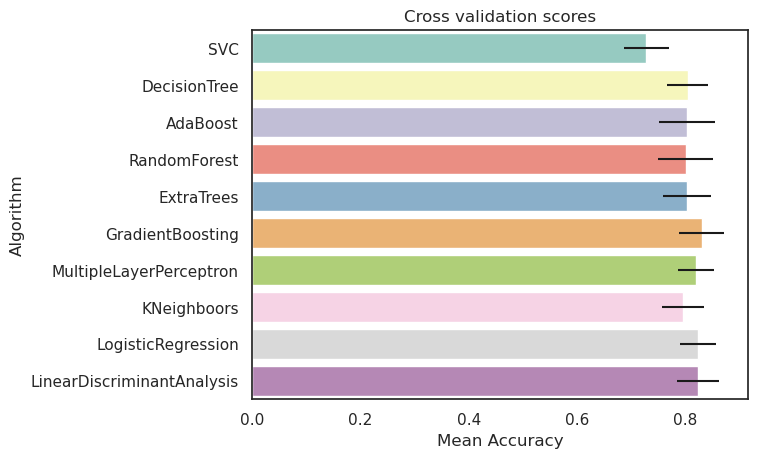

In [66]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x='CrossValMeans', y='Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

앙상블 모델링을 위해 **SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting** 분류기 선택

#### 6.1.2 Hyperparameter tunning for best models
SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting 분류기에 대한 GridSearchCV 실행
- CPU가 4개이므로 n_jobs=4

In [67]:
# AdaBoost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {'base_estimator__criterion':['gini', 'entropy'],
                 'base_estimator__splitter':['best', 'random'],
                 'algorithm':['SAMME','SAMME.R'],
                 'n_estimators':[1,2],
                 'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}
gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsadaDTC.fit(X_train, Y_train)
ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [68]:
gsadaDTC.best_score_

0.8275536261491316

In [69]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

ex_param_grid = {'max_depth':[None],
                'max_features':[1, 3, 10],
                'min_samples_split':[2, 3, 10],
                'min_samples_leaf':[1, 3, 10],
                'bootstrap':[False],
                'n_estimators':[100, 300],
                'criterion':['gini']}

gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8308605720122575

In [70]:
# RandomForest
RFC = RandomForestClassifier()

rf_param_grid = {'max_depth':[None],
                'max_features':[1, 3, 10],
                'min_samples_split':[2, 3, 10],
                'min_samples_leaf':[1, 3, 10],
                'bootstrap':[False],
                'n_estimators':[100, 300],
                'criterion':['gini']}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8342824310520941

In [71]:
# Gradient Boosting
GBC = GradientBoostingClassifier()

gb_param_grid = {'loss':['deviance'],
                'n_estimators':[100, 200, 300],
                'learning_rate':[0.1, 0.05, 0.01],
                'max_depth':[4, 8],
                'min_samples_leaf':[100, 150],
                'max_features':[0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8286133810010213

In [72]:
# SVC
SVMC = SVC(probability=True)
svc_param_grid = {'kernel':['rbf'],
                 'gamma':[0.001, 0.01, 0.1, 1],
                 'C':[1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

#### 6.1.3 Plot learning curves
Learning curve는 훈련 데이터에 미치는 영향 그리고 훈련 크기가 정확도에 미치는 영향을 확인하는 좋은 방법임

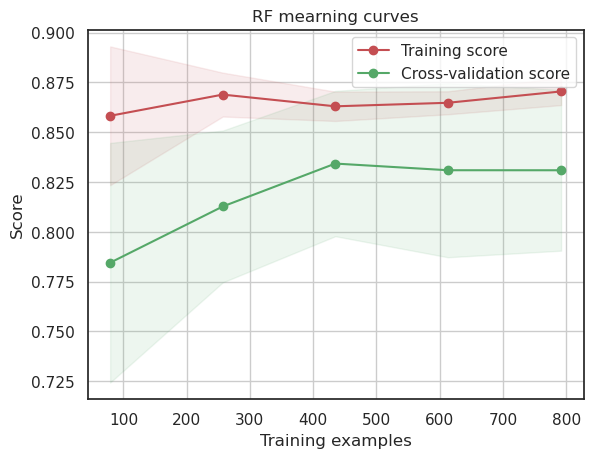

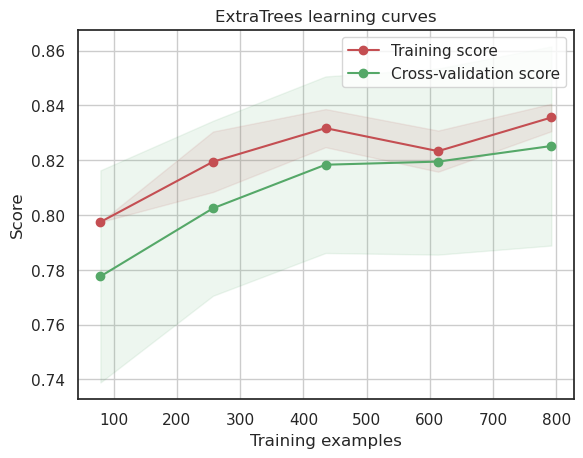

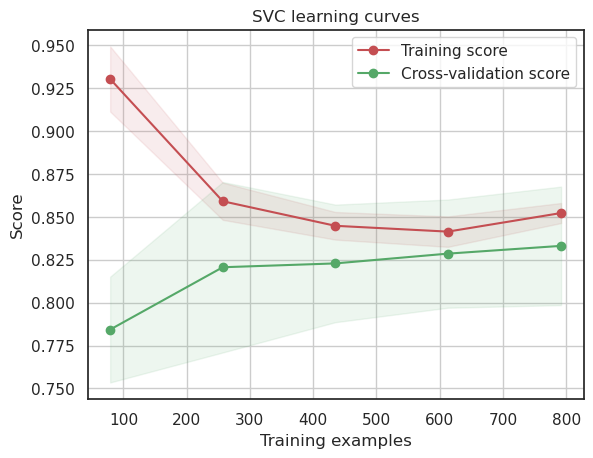

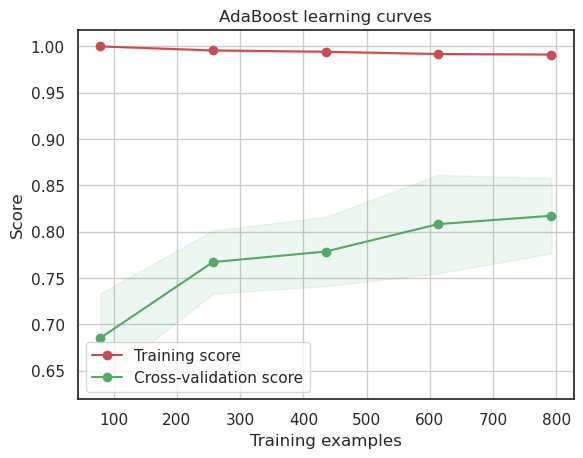

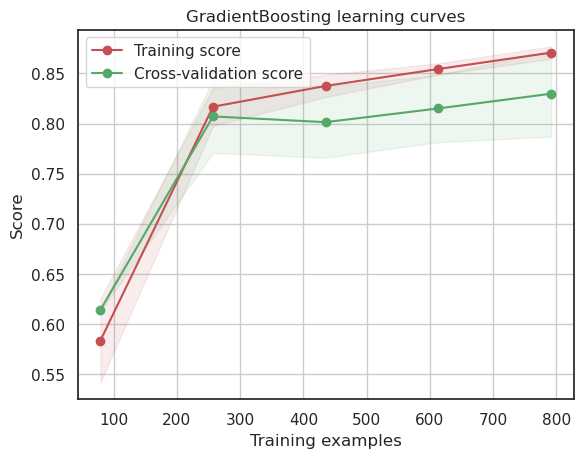

In [73]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    
    plt.legend(loc='best')
    return plt

g = plot_learning_curve(gsRFC.best_estimator_, 'RF mearning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, 'ExtraTrees learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', X_train, Y_train, cv=kfold)

GradientBoosting과 AdaBoosting은 훈련데이터에서 과적합되는 경향
- cv 곡선이 증가함에 따라 학습 데이터에서 더 나은 성능을 보임

SVC와 ExtraTrees 분류기는 훈련과 cv 곡선이 서로 가깝기 때문에 예측을 일반화함

#### 6.1.4 Feature importance of tree based classifiers
- 승객 생존 예측에 더 유의미한 feature를 확인하기 위해, 4개의 트리 기반 분류기에 대해 중요도 표시

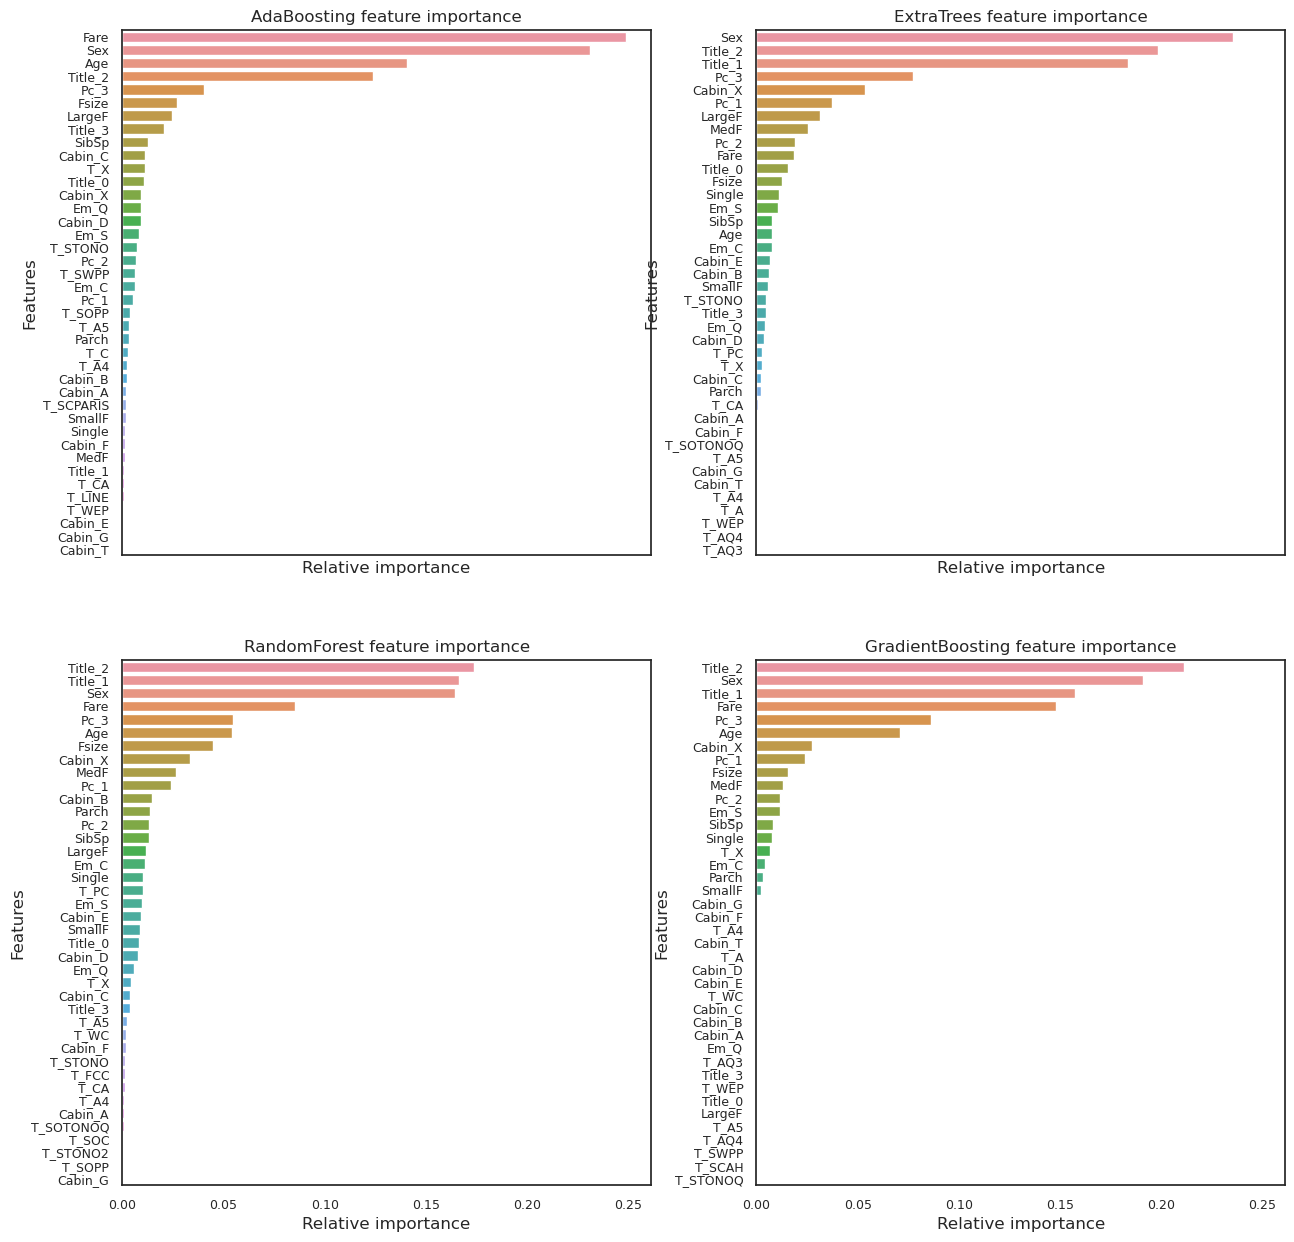

In [74]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows= nrows, ncols=ncols, sharex='all', figsize=(15,15))

names_classifiers=[('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40], x=classifier.feature_importances_[indices][:40], orient='h', ax=axes[row][col])
        g.set_xlabel('Relative importance', fontsize=12)
        g.set_ylabel('Features', fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name+' feature importance')
        nclassifier += 1

4개의 분류기가 상대적 중요성에 따라 서로 다른 상위 feature를 가짐
- 이는 동일한 feature를 기반으로 예측하지 않음을 의미
- 그럼에도 불구하고, 'Fare', Title_2', 'Age', 'Sex'와 같은 공통적인 중요한 feature를 공유함
- 'Title_2'는 'Sex'와 높은 상관관계를 나타냄

위 4개의 분류기의 feature 중요성에 따르면 **생존 예측은 배 안에서의 위치보다 승객의 Age, Sex, family size, social standing과 더 관련있음**

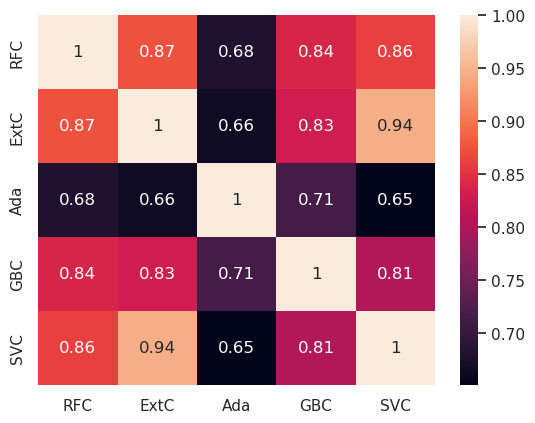

In [75]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name='ExtC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name='SVC')
test_Survived_AdaC = pd.Series(ada_best.predict(test), name='Ada')
test_Survived_GBC = pd.Series(GBC_best.predict(test), name='GBC')

ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

Adaboost와 다른 분류기를 비교했을 때, 5개 분류기의 예측이 매우 유사함

5개의 분류기는 비슷한 예측을 보이지만 몇가지 차이점이 존재함

이러한 차이는 5개의 분류 예측 사이의 앙상블 vote를 고려하기에 충분

### 6.2 Ensemble modeling

#### 6.2.1 Combining models
5개의 분류기로부터 예측을 결합하기 위해 **voting 분류기** 사용

각 투표 확률을 고려하기 위해 voting 매개변수를 'soft'로

In [76]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, Y_train)

### 6.3 Prediction

#### 6.3.1 Predict and Submit results

In [77]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')

result = pd.concat([IDtest, test_Survived], axis=1)

result.to_csv('ensemble_python_voting.csv', index=False)